In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)  

%matplotlib inline

### Data Sets

In [3]:
df_train = pd.read_csv('../Data/googlestock/Google_Stock_Price_Train.csv', parse_dates=['Date'])
df_test  = pd.read_csv('../Data/googlestock/Google_Stock_Price_Test.csv', parse_dates=['Date'])

In [4]:
print(df_train['Date'].min())
print(df_train['Date'].max())

2012-01-03 00:00:00
2016-12-30 00:00:00


In [5]:
df_train.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


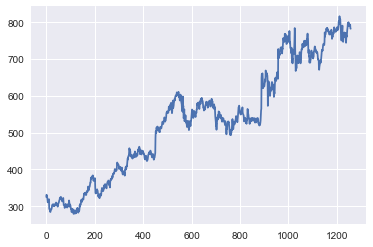

In [6]:
plt.plot(df_train['Open'])

In [7]:
df_test.head()

,Date,Open,High,Low,Close,Volume
0,2017-01-03,778.81,789.63,775.80,786.14,"1,657,300"
1,2017-01-04,788.36,791.34,783.16,786.90,"1,073,000"
2,2017-01-05,786.08,794.48,785.02,794.02,"1,335,200"
3,2017-01-06,795.26,807.90,792.20,806.15,"1,640,200"
4,2017-01-09,806.40,809.97,802.83,806.65,"1,272,400"


In [8]:
train = df_train.iloc[:, 1:2].values

In [9]:
test = df_test.iloc[:, 1:2].values

### Data Preparation

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
test  = sc.transform(test)

**Defining number of time-steps for the RNN to remember when predicting.**

- Wrong number may lead to overfitting and inaccurated results.
- At each time *t*, the RNN will look at the *n* stock prices before time *t* and based on this trend 
it will try to predict the next output.

In [12]:
X_train = []
y_train = []
for i in range(60, len(df_train)): # Starting at 60, so we can look back
    X_train.append(train[i-60:i, 0])
    y_train.append(train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [13]:
X_train.shape

(1198, 60)

In [14]:
y_train.shape

(1198,)

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [17]:
print(X_train.min(), X_train.max())

0.0 1.0


### Modeling

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [19]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [20]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
__________

In [21]:
import keras 
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

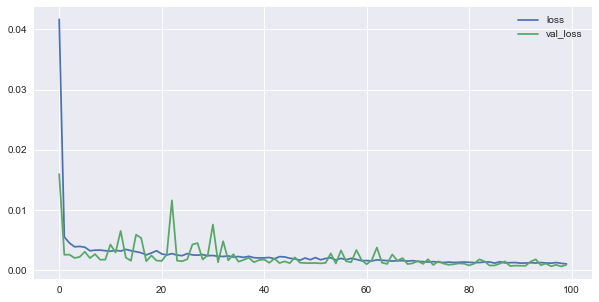

In [22]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0, callbacks=[plot_losses])

In [23]:
both = np.concatenate((df_train['Open'], df_test['Open']), axis = 0)

In [26]:
inputs = both[len(both) - len(df_test) - 60:]
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)

In [31]:
inputs.shape

(80, 1)

In [27]:
X_test = []
for i in range(60, len(df_test)+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [28]:
print(X_test.min(), X_test.max())

0.865894039735 1.03930724012


In [29]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

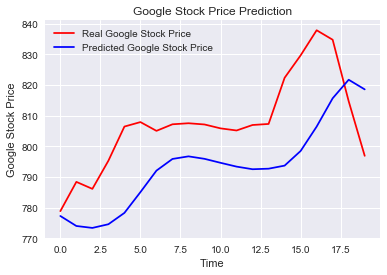

In [30]:
# Visualising the results
plt.plot(df_test['Open'], color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()